In [567]:
import random

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [295]:
def load_csv():
    df = pd.read_csv('plant_list.csv')
    df.drop(['Unnamed: 1', 'Unnamed: 15'], axis=1, inplace=True)
    df.columns = [c.lower() for c in df.columns]
    df = df.rename(columns={'spacing': 'diameter'})

    bool_cols = ['dry', 'medium', 'moist', 'sun', 'partial', 'shade', 'deer resistant']
    for col in bool_cols:
        b = pd.Series([False] * df.shape[0])
        b[df[col] == 'Y'] = True
        df[col] = b
    months = {
        mon: i + 3 for i, mon in enumerate(
            ['Mar', 'Apr', 'May', 'June', 'July', 'Aug', 'Sep', 'Oct']
            )
            }
    for k, v in months.items():
        df = df.replace(k, v)
    timecols = ['mintime', 'maxtime']
    for col in timecols: df[col] = pd.to_numeric(df[col])

    df['item'] = df['plant'].apply(lambda x: clean_str(x))
    df.set_index('item', inplace=True)
    return df

def clean_str(s):
    return s.replace("'", '').replace(' ', '_').lower()

In [756]:
def pick_random_spot(space_dimensions):
    scale = 1.1
    return (random.random() * space_dimensions[0] * scale - space_dimensions[0] * (scale - 1) / 2,
            random.random() * space_dimensions[1] * scale - space_dimensions[1] * (scale - 1) / 2)

def circle_area(radius):
    return np.pi * radius ** 2

def space_remaining(items, df_inventory, space_dimensions):
    return (space_dimensions[0] * space_dimensions[1] 
            - df_inventory.loc[list(items)]['diameter'].apply(lambda x: np.pi * (x/2)**2).sum())

In [712]:
colours = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
# Sort colors by hue, saturation, value and name.
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgba(colour)[:3])), name)
                for name, colour in colours.items())
COLOUR_NAMES = [name for hsv, name in by_hsv if (hsv[2] < 0.8) and (0.2 < hsv[2])]

def generate_circle(r, scale_pts=100):
    theta = np.linspace(0, 2 * np.pi, 100).tolist()
    return [r * np.cos(th) for th in theta], [r * np.sin(th) for th in theta]

def generate_centred_circle(x, y, r):
    x_offset, y_offset = generate_circle(r)
    return [x + xi for xi in x_offset], [y + yi for yi in y_offset]

def plot_circle(x, y, r, ax):
    x_pts, y_pts = generate_centred_circle(x, y, r)
    ax.plot(x_pts, y_pts, 'k:', linewidth=1)
    ax.set(aspect='equal')

def plot_plan(items, xy, df_inventory, space_dimensions):
    f, ax = plt.subplots()
    for i, item in enumerate(items):
        plot_circle(xy[i, 0], xy[i, 1], df_inventory.loc[item]['diameter'] / 2, ax)
    ax.plot([0, space_dimensions[0], space_dimensions[0], 0, 0], [0, 0, space_dimensions[1], space_dimensions[1], 0], 'k--', linewidth=2)
    return f, ax



23% unused


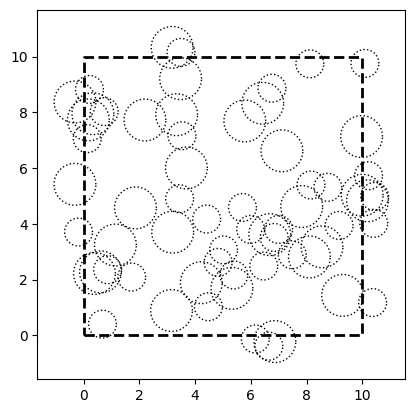

In [768]:
def create_initial_plan(n_types, df_inventory, space_dimensions):
    
    choices = df_inventory[df_inventory['diameter'] < min(space_dimensions) / 4].sample(n_types)
    items, x, y = [], [], []
    # optimal packing density of uniform circles is ~90%
    buffer = 10 * 2
    while True:
        items += [choices.sample(1).index[0]]
        nx, ny = pick_random_spot(space_dimensions)
        x += [nx]
        y += [ny]

        if (space_remaining(items, df_inventory, space_dimensions)
            < buffer * (np.pi * (choices.loc[list(items)]['diameter'].mean() / 2) ** 2)): break
    print(f'{space_remaining(items, df_inventory, space_dimensions) / np.prod(space_dimensions):.0%} unused')
    return tuple(items), np.vstack((np.array(x), np.array(y))).transpose()

def shake_plan_once(items, xy, movement, inventory, space_dimensions):

    possible_steps = int(1e1)
    
    res = xy
    score = optimisation_function(items, xy, inventory, space_dimensions)
    for i in range(possible_steps):
        xy_test = xy + np.random.uniform(-movement, movement, xy.shape)
        new_score = optimisation_function(items, xy_test, inventory, space_dimensions)
        # print(score, new_score, abs(xy - xy_test).sum())
        if new_score < score:
            score = new_score
            res = xy_test
    return res


def shake_up_plan(items, xy, df_inventory, space_dimensions):

    steps = int(1e4)
    max_movement = max(space_dimensions) / 3
    min_movement = df_inventory['diameter'].min() / 2
    movement_steps = np.logspace(max_movement, min_movement, steps)

    # split apart the inventory
    radii = df_inventory.loc[list(items)]['diameter'].values / 2
    inventory = (
        radii, 
        radii.reshape((len(items), 1)) + radii.reshape((1, len(items)))
        )

    res = xy
    for movement in movement_steps:
        res = shake_plan_once(items, res, movement, inventory, space_dimensions)
    return res

df_inventory = load_csv()
LENGTH = 10; WIDTH = 10;
garden_size = (WIDTH, LENGTH)

items, xy = create_initial_plan(6, load_csv(), garden_size)
plot_plan(items, xy, df_inventory, garden_size)

radii = df_inventory.loc[list(items)]['diameter'].values / 2
inventory = (
    radii, 
    radii.reshape((len(items), 1)) + radii.reshape((1, len(items)))
    )

def optimisation_function(items, xy, inventory, space_dimensions):
    def fall_to_bottom(): # test case
        return xy[:,1].sum() / (xy.shape[0])

    # def centre_out_of_bounds():
    #     def undershoot(axis):
    #         return -xy[xy[:, axis] < 0, axis].sum()
    #     def overshoot(axis):
    #         a = xy[space_dimensions[axis] <= xy[:, axis], axis]
    #         return a.sum() - a.shape[0] * space_dimensions[axis]
    #     return (undershoot(0) + undershoot(1) + overshoot(0) + overshoot(1)) / (xy.shape[0] * 2)
    
    def anything_out_of_bounds():
        def undershoot(axis):
            a = xy[:, axis] - radii
            return -a[a < 0].sum()
        def overshoot(axis):
            b = xy[:, axis] + radii
            a = b[space_dimensions[axis] <= b]
            return a.sum() - a.shape[0] * space_dimensions[axis]
        power = 4
        return (undershoot(0) + undershoot(1) + overshoot(0) + overshoot(1)) ** power / ((xy.shape[0] * 2) ** power)
              
    def circles_dont_overlap(): 
        # want the sum of the two radii <= pairwise distance
        a = (combi_radii - pairwise_distance).flatten()
        return abs(a[0 < a]).sum() ** 0.75 / (xy.shape[0] ** power))

    radii, combi_radii = inventory
    
    n = len(items)
    pairwise_distance = scipy.spatial.distance.cdist(xy, xy, 'euclidean')
    # (np.sqrt(  # Euclidean distance - this is 2x slower than scipy version
    #     (xy[:, 0].reshape((n, 1)) - xy[:, 0].reshape((1, n))) ** 2 
    #     + (xy[:, 1].reshape((n, 1)) - xy[:, 1].reshape((1, n))) ** 2
    #     ))
    

    weights = {
        anything_out_of_bounds: 1,
        # centre_out_of_bounds: 5,
        circles_dont_overlap: 1
    }
    return sum([k() * v for k, v in weights.items()])

(<Figure size 640x480 with 1 Axes>, <Axes: >)

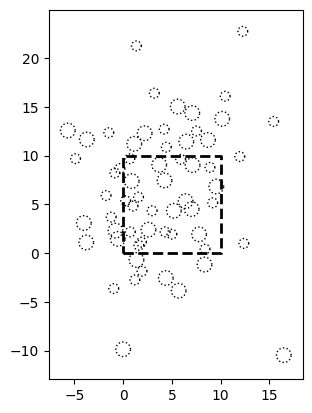

In [769]:
xy_new = shake_up_plan(items, xy, df_inventory, garden_size)
plot_plan(items, xy_new, df_inventory, garden_size)

16% unused


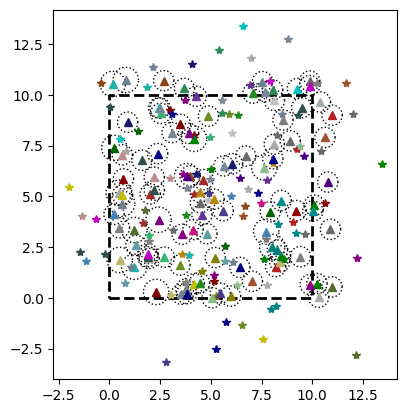

In [736]:
items, xy = create_initial_plan(6, load_csv(), garden_size)
radii = df_inventory.loc[list(items)]['diameter'].values / 2
inventory = (
    radii, 
    radii.reshape((len(items), 1)) + radii.reshape((1, len(items)))
    )

res = shake_plan_once(items, xy, 3.5, inventory, garden_size)

f, ax = plot_plan(items, xy, df_inventory, garden_size)
cols = [COLOUR_NAMES[int(i)] for i in np.linspace(start=0, stop=len(COLOUR_NAMES) - 1, num=xy.shape[0])]
for i in range(xy.shape[0]):
    ax.plot(xy[i, 0], xy[i, 1], color=cols[i], marker='^')
    ax.plot(res[i, 0], res[i, 1], color=cols[i], marker='*')
# print(cols)

(<Figure size 640x480 with 1 Axes>, <Axes: >)

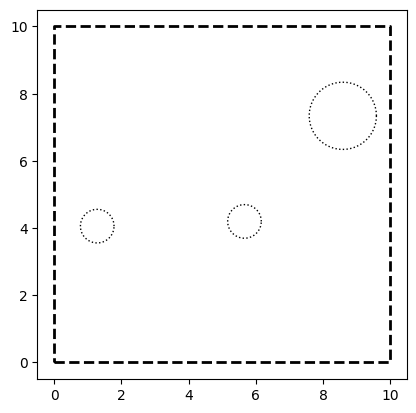

['dimgray', 'brown', 'olive', 'green', 'c', 'navy', 'mediumvioletred']


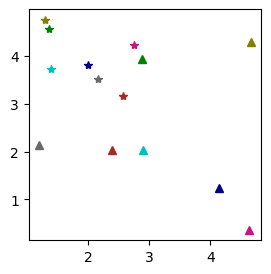

In [543]:
f, ax = plt.subplots(figsize=(3, 3))
cols = [COLOUR_NAMES[int(i)] for i in np.linspace(start=0, stop=len(COLOUR_NAMES) - 1, num=xy.shape[0])]
for i in range(xy.shape[0]):
    plt.plot(xy[i, 0], xy[i, 1], color=cols[i], marker='^')
    plt.plot(xy_new[i, 0], xy_new[i, 1], color=cols[i], marker='*')
print(cols)


In [544]:
n = xy_new.shape[0]
radii = df_inventory.loc[list(items)]['diameter'].values / 2
combi_radii = radii.reshape((len(items), 1)) + radii.reshape((1, len(items)))
pairwise_distance_new = (np.sqrt(
        (xy_new[:, 0].reshape((n, 1)) - xy_new[:, 0].reshape((1, n))) ** 2 
        + (xy_new[:, 1].reshape((n, 1)) - xy_new[:, 1].reshape((1, n))) ** 2
        ))
pairwise_distance_old = (np.sqrt(
        (xy[:, 0].reshape((n, 1)) - xy[:, 0].reshape((1, n))) ** 2 
        + (xy[:, 1].reshape((n, 1)) - xy[:, 1].reshape((1, n))) ** 2
        ))

In [508]:
df_inventory.loc[list(items)][['plant', 'diameter']].value_counts()

plant              diameter
Beardtongue        2.0         3
Yellow Coneflower  1.5         2
dtype: int64

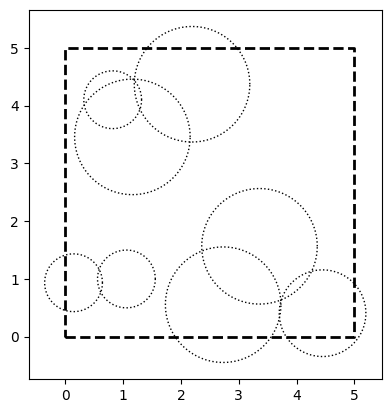

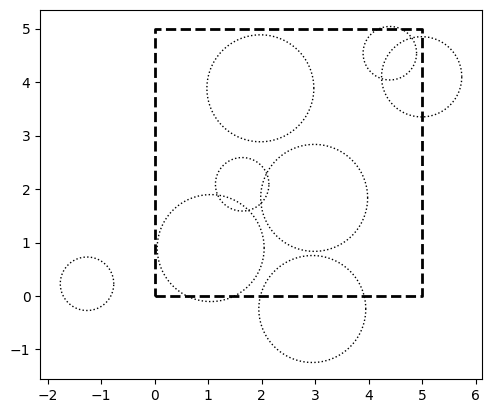